Goal of this notebook is to employ a Canny edge detector, than classify the difference between external and internal edges in the image.

With the internal edges, we will define new parts of the threshold image and thus enable finer watershed

In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
import math
import copy
import pandas as pd
import os

import sys
sys.path.append("..")
from Utility.segmentation_utils import *
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [2]:
interesting_files = ['../Images/Additional/L1 2.5, 5, 10 nM mixing assembly/L1 2.5 nM mixing /2.5nM_L1_inversion_01.tif',
                    "../Images/Additional/Si embed/2_01.tif"]
Alexa_files = glob.glob('../Images/Additional/Images for model (from Alexa)/*')
#print(Alexa_files)
IS = ImageSegmenter(interesting_files[1],top_boundary=0,bottom_boundary=920,override_exists=False)

Image Segmenter on 2_01 created!


In [3]:
@interact
def adjust_watershed_params(
                    kernel_size=widgets.IntSlider(min=1,max=11, step=2,value=3),
                    dist_scale=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.35),
                    edge_modification=False,
    tu=widgets.IntSlider(min=0,max=255, step=2,value=120),
    tl=widgets.IntSlider(min=0,max=255, step=2,value=40),
    blur_size=widgets.IntSlider(min=1,max=11, step=2,value=3),
    blur_image=False,
    overlay_image=False
):
    IS.kernel = np.ones(kernel_size)
    IS.distance_scale=dist_scale
    IS.canny_tu = tu
    IS.canny_tl = tl
    IS.blur_size=(blur_size,blur_size)
    IS.process_images(blur_image,edge_modification)
    fig, ax = plt.subplots(figsize=(18,20))
    if overlay_image:
        logical = copy.deepcopy(IS.markers2)
        logical[logical < 2] = 0
        logical[logical > 1] = 2
        test = copy.deepcopy(IS.img2)
        test[logical != 2] = test[logical != 2]*.5 
        plt.imshow(test)
    else:
        plt.imshow(IS.markers)

#logical = copy.deepcopy(markers2)
#print(np.unique(logical))
#logical[logical < 2] = 0
#logical[logical > 1] = 2
#test = copy.deepcopy(IS.img2)
#test[logical != 2] = test[logical != 2]*.5 
#fig, ax = plt.subplots(figsize=(18,20))
#ax.imshow(test)
#plt.imshow(IS.thresh)

interactive(children=(IntSlider(value=3, description='kernel_size', max=11, min=1, step=2), FloatSlider(value=…

(920, 1280) (920, 1280)
(920, 1280)


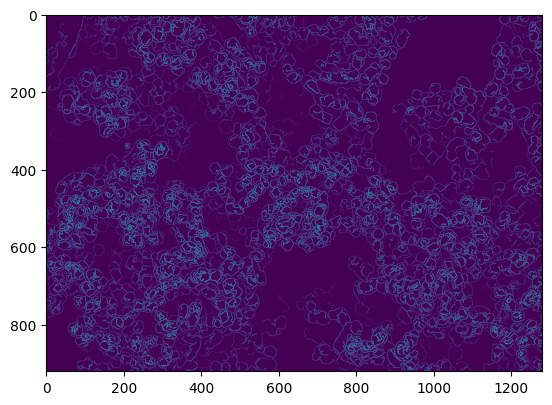

In [4]:
from PIL import Image
canny_edge = IS.Canny_edge((3,3),40,120)
img2 = IS.img2
plt.imshow(img2)
print(canny_edge.shape,img2.shape)
im_edges = cv2.GaussianBlur(img2,(5,5),cv2.BORDER_DEFAULT) # NOTE: GaussianBlur seems to have issues, doesn't produce good results

im_edges[canny_edge == 0] = 0
print(im_edges.shape)
plt.imshow(im_edges)
Image.fromarray(im_edges).save("../../test.png")

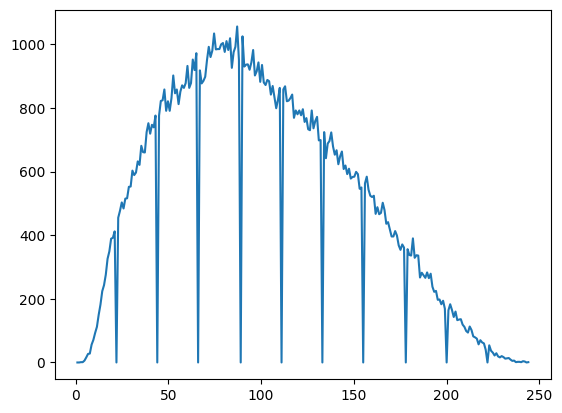

In [5]:
histogram, bin_edges = np.histogram(im_edges,bins=256)

# remove 0 vals
bin_edges = bin_edges[1:]
histogram = histogram[1:]
plt.plot(bin_edges[:-1],histogram)

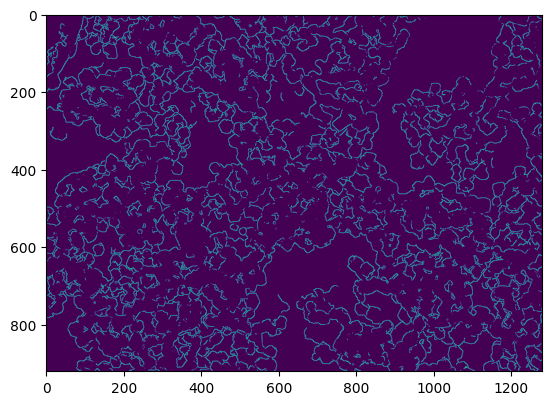

In [6]:
# See which edges correspond to above the max intensity
cut_off = np.argmax(histogram)

# Define bright edges
bright_edges = copy.deepcopy(im_edges)
bright_edges[bright_edges < cut_off] = 0
bright_edges[bright_edges > 0] = 255

# define dark edges
dark_edges = copy.deepcopy(im_edges)
dark_edges[dark_edges > cut_off] = 0
dark_edges[dark_edges > 0] = 255

plt.imshow(dark_edges)

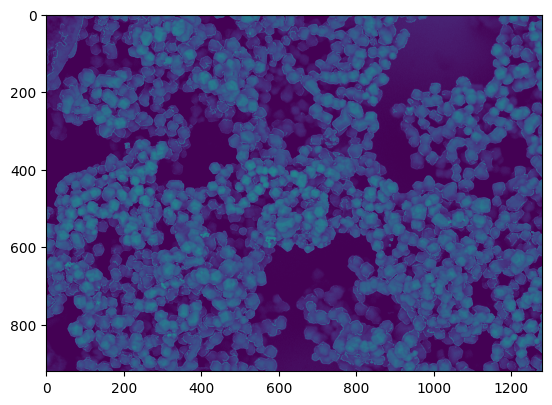

In [7]:
dark_broad = cv2.GaussianBlur(dark_edges,(1,1),cv2.BORDER_DEFAULT)
test_img = copy.deepcopy(IS.img2)
test_img[dark_broad == 0] = test_img[dark_broad == 0] * .3

plt.imshow(test_img)

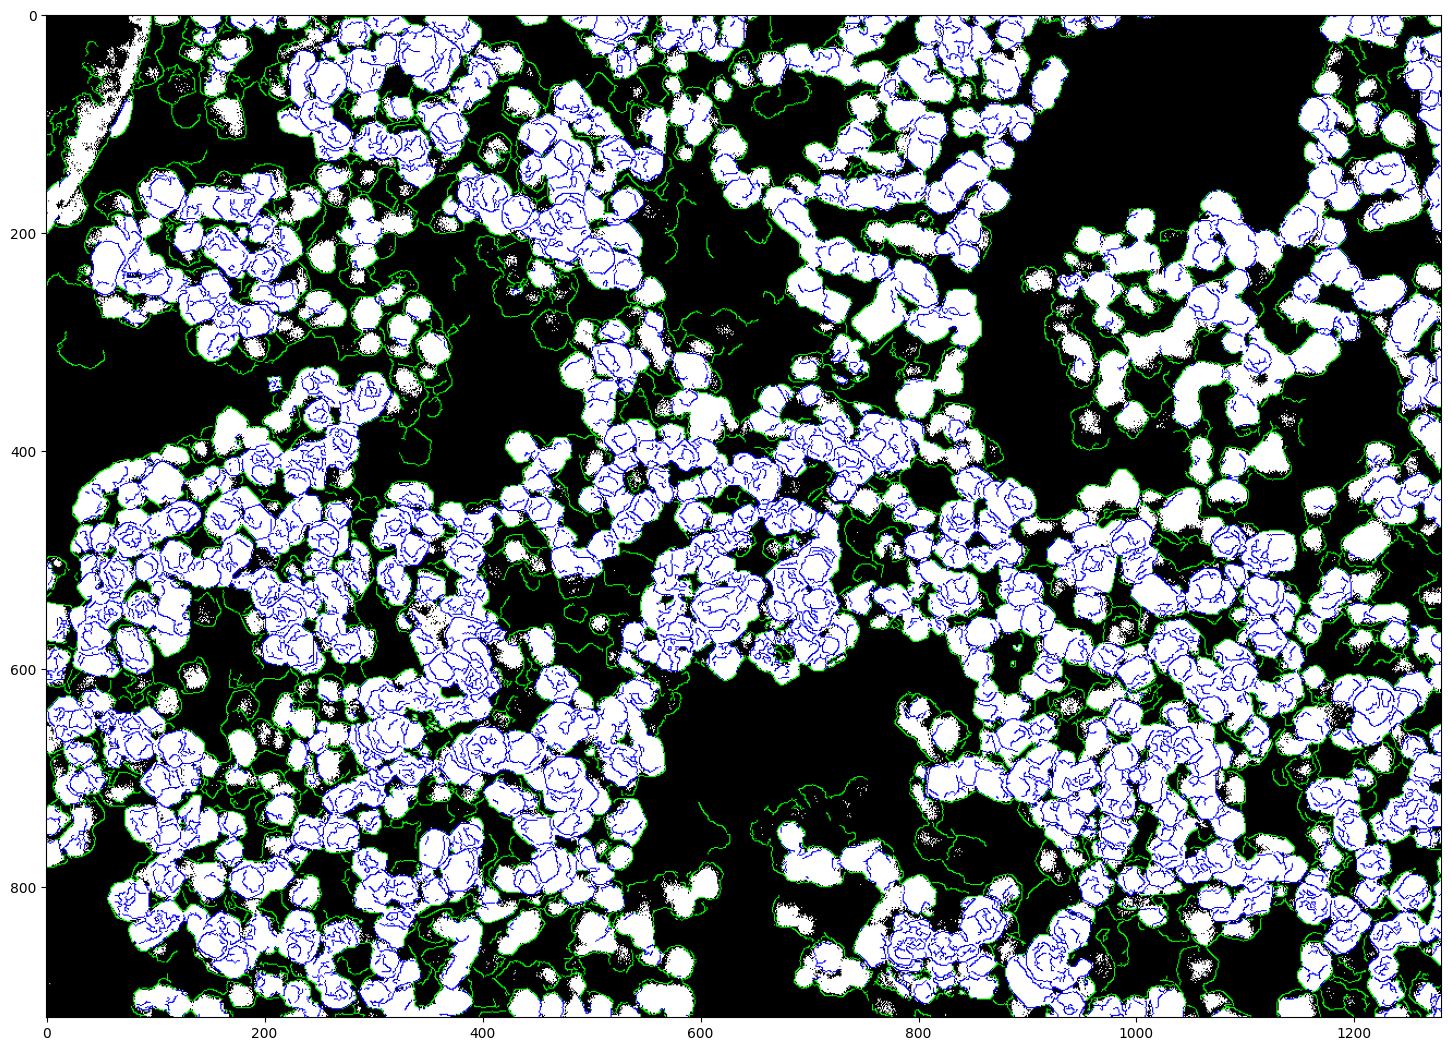

In [8]:
#
# Check where bright and dark edges fall
#

test_img = copy.deepcopy(IS.thresh)
test_img_color = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGB)
test_img_color[dark_broad > 0] = (0,255,0)
test_img_color[bright_edges > 0] = (0,0,255)

fig, ax = plt.subplots(figsize=(18,20))
plt.imshow(test_img_color)
Image.fromarray(test_img_color).save("../../test_colors.png")

310 304


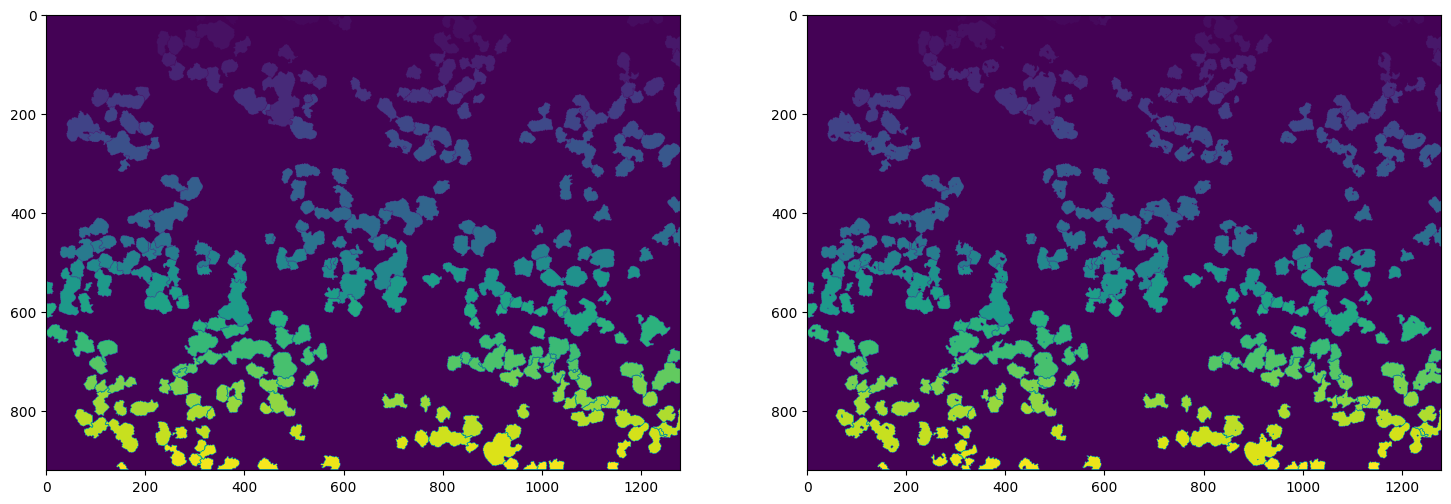

In [11]:
#
# Attempt Watershed with Adjusted 
# 
th = IS.thresh
th_edge = IS.thresh-dark_edges

bg_mark = IS._bg_mark

dist = cv2.distanceTransform(th,cv2.DIST_L2,5)
dist_edge = cv2.distanceTransform(th_edge,cv2.DIST_L2,5)

dist_mult = .5
ret2, fg_mark = cv2.threshold(dist,dist_mult*dist.max(),255,0)
ret2_edge, fg_mark_edge = cv2.threshold(dist_edge,dist_mult*dist_edge.max(),255,0)

fg_mark = np.uint8(fg_mark)
fg_mark_edge = np.uint8(fg_mark_edge)

unknown = cv2.subtract(bg_mark,fg_mark)
unknown_edge = cv2.subtract(bg_mark,fg_mark_edge)

outputs = cv2.connectedComponentsWithStats(fg_mark)
label_increment = 1
markers = outputs[1]+label_increment
markers[unknown == 255]=0
markers2 = cv2.watershed(IS.img3,markers)

outputs_edge = cv2.connectedComponentsWithStats(fg_mark_edge)
label_increment = 1
markers_edge = outputs[1]+label_increment
markers_edge[unknown_edge == 255]=0
markers2_edge = cv2.watershed(IS.img3,markers_edge)

fig, ax = plt.subplots(1,2,figsize=(18,20))
ax[0].imshow(markers2)
ax[1].imshow(markers2_edge)

print(len(np.unique(markers2)),len(np.unique(markers2_edge)))

In [ ]:
#
# Check alternate kernel for getting bright and dark edges from canny
# Instead of GaussianBlurred, grab max b


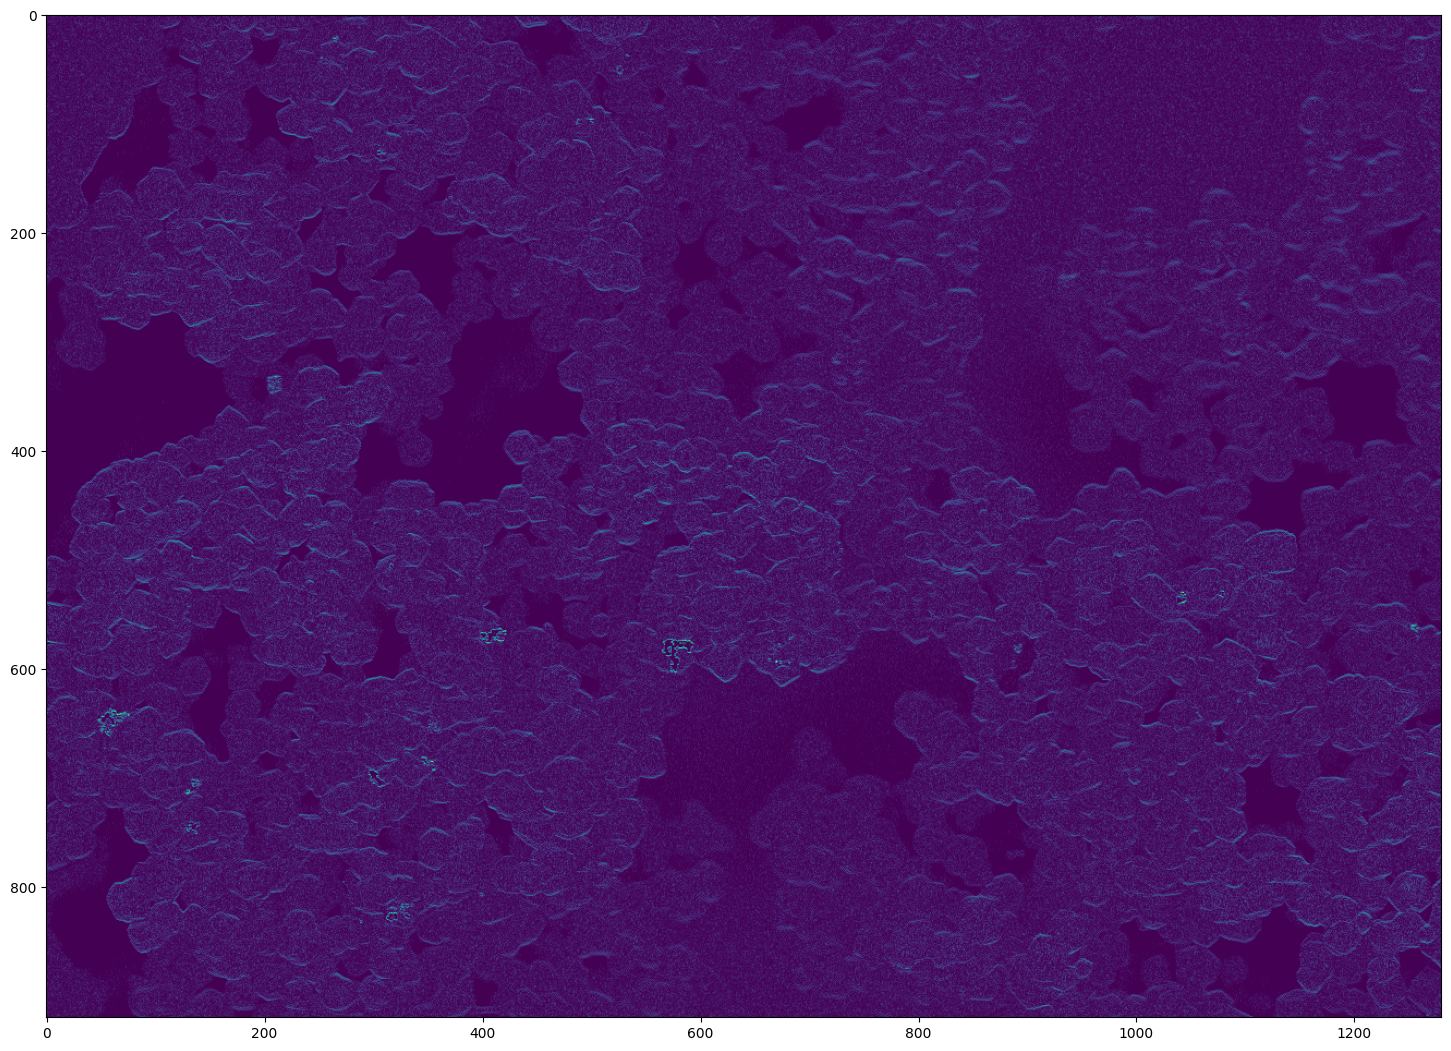

In [18]:
#
# Check tophat transform
#
kern = (3,3)
th_img = cv2.morphologyEx(IS.img2,cv2.MORPH_TOPHAT,kern)
bh_img = cv2.morphologyEx(IS.img2,cv2.MORPH_BLACKHAT,kern)
fig, ax = plt.subplots(figsize=(18,20))
ax.imshow(th_img+bh_img)